In [27]:
import shutil, random, os
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [21]:
#Get data into one folder
target_dir = "C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\Data"
source_dir= "C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\genres"
i = 0
type(os.listdir(source_dir))
for folder in os.listdir(source_dir):
    sub_folder = os.path.join(source_dir,folder)
    print(sub_folder)
    for file in os.listdir(sub_folder):
        shutil.move(os.path.join(sub_folder,file),target_dir)


C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\genres\blues
C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\genres\classical
C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\genres\country
C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\genres\disco
C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\genres\hiphop
C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\genres\jazz
C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\genres\metal
C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\genres\pop
C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\genres\reggae
C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\genres\rock


In [26]:
'''Next up, split them into training data folder and test folder'''
n = 0
train_dir = "C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\Data\train_Data"
test_dir = "C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\Data\test_Data"
for file in os.listdir(target_dir):
    n += 1

test_ind = random.sample(range(n),200) #200 Test and 800 Train
i=0
for file in os.listdir(target_dir):
    if i in test_ind:
        shutil.move(os.path.join(target_dir,file), test_dir)
    else:
        shutil.move(os.path.join(target_dir,file), train_dir)
    i = i+1

In [40]:
'''Find out all the genres and create folders for them'''
genres = {}
for file in os.listdir(train_dir):
    genre = file.split(".")[0]
    genres[genre] = 1


In [58]:
'''Create folders so that I can the push classified audio into folders'''
for genre in list(genres.keys()):
    dir_name = str(genre)
    dir_path = os.path.join(test_dir,dir_name)
    os.makedirs(dir_path)
    genres[genre] = dir_path

In [90]:
'''Create a dataframe that holds their previous names, new names and genre for train and test folders'''
def create_metadata(folder):
    g = []
    names = []
    for file in os.listdir(folder):
        temp = file.split(".")
        g.append(temp[0])
        names.append(file)
    df = pd.DataFrame({"Names":names, "y":g})
    return df

In [92]:
training_metadata = create_metadata(train_dir)
testing_metadata = create_metadata(test_dir)

In [103]:
'''Now create Spectrogram for each song in train and test folders'''
def create_spectrogram(filename,name, loc):
    #Filename: what has to be converted
    #Name: Name of the converted file (generated jpg)
    #loc: Where the jpg should be saved
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = str(loc)+ r"\ " + name + '.jpg'
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

In [131]:
test_spectro_dir = r"C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\Data\test_spectro"
train_spectro_dir = r"C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\Data\train_spectro"

In [144]:
'''Loop over the training data and test data and create spectrograms that you can feed to cnns'''
for file in os.listdir(test_dir):
    loc = test_spectro_dir #Where the spectrograms will be stored
    outname = file #The name of the jpg file
    inname = os.path.join(test_dir,file) #The file to convert
    create_spectrogram(inname, outname, loc)

In [148]:
for file in os.listdir(train_dir):
    loc = train_spectro_dir
    outname = file
    inname = os.path.join(train_dir,file)
    create_spectrogram(inname, outname, loc)

In [152]:
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing import image

In [156]:
'''Now prepare the spectrograms for keras. Then create a dataframe: Processed Images, Classes
We are preparing the predictor columns now
'''
train_image = []
for file in os.listdir(train_spectro_dir):
    fname = os.path.join(train_spectro_dir, file)
    img = image.load_img(fname, target_size=(64,64,3), grayscale=False) #Load the image. keras will do some processing
    img = image.img_to_array(img) #Convert it into numeric array so that the CNN can "read" it
    img = img/255 #Normalize it. 0-1 range now
    train_image.append(img)
x_train = np.array(train_image)

In [159]:
test_image = []
for file in os.listdir(test_spectro_dir):
    fname = os.path.join(test_spectro_dir, file)
    img = image.load_img(fname, target_size=(64,64,3), grayscale=False) #Load the image. keras will do some processing
    img = image.img_to_array(img) #Convert it into numeric array so that the CNN can "read" it
    img = img/255 #Normalize it. 0-1 range now
    test_image.append(img)
x_test = np.array(test_image)d

199

In [193]:
'''One hot encode the target classes. Preparing the target column now. With this data prep will finally be over'''
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(training_metadata["y"])
y_train = to_categorical(y_train)
y_test = le.fit_transform(testing_metadata["y"])
y_test = to_categorical(y_test)

In [177]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization,Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0

In [189]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(optimizers.RMSprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 31, 31, 64)       

In [191]:
y_train = training_metadata["y"]
y_test = testing_metadata["y"]

In [196]:
model_save_loc = r"C:\Courses\Edvancer 53k course\Deep Learning\Projects\Music Genre Identification\Data\models"
training = model.fit(x_train, y_train, epochs=100)

Epoch 1/100
26/26 [==============================] - 11s 435ms/step - loss: 1.9904 - accuracy: 0.2747
Epoch 2/100
26/26 [==============================] - 11s 421ms/step - loss: 1.9296 - accuracy: 0.2946
Epoch 3/100
26/26 [==============================] - 12s 479ms/step - loss: 1.8420 - accuracy: 0.3296
Epoch 4/100
26/26 [==============================] - 15s 564ms/step - loss: 1.8097 - accuracy: 0.3533
Epoch 5/100
26/26 [==============================] - 17s 672ms/step - loss: 1.7614 - accuracy: 0.3633
Epoch 6/100
26/26 [==============================] - 15s 579ms/step - loss: 1.7451 - accuracy: 0.3533
Epoch 7/100
26/26 [==============================] - 15s 560ms/step - loss: 1.7128 - accuracy: 0.3645
Epoch 8/100
26/26 [==============================] - 13s 503ms/step - loss: 1.6493 - accuracy: 0.3733
Epoch 9/100
26/26 [==============================] - 13s 483ms/step - loss: 1.6447 - accuracy: 0.3970
Epoch 10/100
26/26 [==============================] - 12s 469ms/step - loss: 1.609

26/26 [==============================] - 12s 478ms/step - loss: 0.1341 - accuracy: 0.9513
Epoch 81/100
26/26 [==============================] - 12s 455ms/step - loss: 0.1909 - accuracy: 0.9413
Epoch 82/100
26/26 [==============================] - 12s 453ms/step - loss: 0.0797 - accuracy: 0.9763
Epoch 83/100
26/26 [==============================] - 12s 454ms/step - loss: 0.1381 - accuracy: 0.9526
Epoch 84/100
26/26 [==============================] - 12s 453ms/step - loss: 0.1243 - accuracy: 0.9538
Epoch 85/100
26/26 [==============================] - 12s 473ms/step - loss: 0.1616 - accuracy: 0.9451
Epoch 86/100
26/26 [==============================] - 12s 455ms/step - loss: 0.1105 - accuracy: 0.9650
Epoch 87/100
26/26 [==============================] - 12s 456ms/step - loss: 0.1185 - accuracy: 0.9613
Epoch 88/100
26/26 [==============================] - 12s 463ms/step - loss: 0.1298 - accuracy: 0.9513
Epoch 89/100
26/26 [==============================] - 12s 464ms/step - loss: 0.1769 - 

In [208]:
predicted = model.predict(x_test)
temp = np.argmax(predicted, axis=1)

In [228]:
predicted_class = le.inverse_transform(temp)

In [229]:
correct = 0
total = 199
for i in range(len(predicted_class)):
    if predicted_class[i] == testing_metadata["y"][i]:
        correct+=1

In [235]:
print(correct/total*100)

50.25125628140703


In [236]:
model.save("MusicGenreFilter")
model.save_weights("MusicFilterWeights.h5")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: MusicGenreFilter\assets


<Figure size 432x288 with 0 Axes>

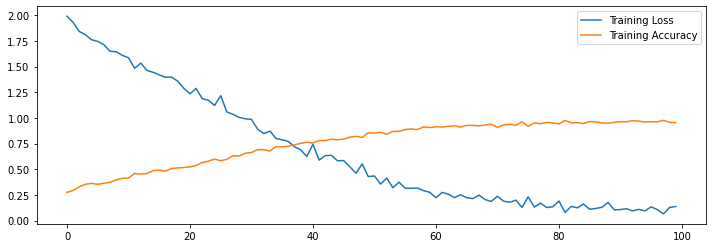

In [243]:
losses = training.history['loss']
accs = training.history['accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs],  ['Loss', 'Accuracy'])):
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[1]))
    plt.legend()
plt.show()

In [246]:
x_train[1:5]

array([[[[0.        , 0.        , 0.01960784],
         [0.00392157, 0.        , 0.00784314],
         [0.01176471, 0.        , 0.00784314],
         ...,
         [0.00392157, 0.        , 0.00784314],
         [0.        , 0.        , 0.01960784],
         [0.        , 0.00392157, 0.01176471]],

        [[0.        , 0.        , 0.01960784],
         [0.        , 0.        , 0.01568628],
         [0.00784314, 0.01176471, 0.03137255],
         ...,
         [0.        , 0.00392157, 0.02745098],
         [0.01568628, 0.        , 0.10588235],
         [0.00392157, 0.        , 0.07450981]],

        [[0.04705882, 0.01960784, 0.14901961],
         [0.05882353, 0.04313726, 0.09803922],
         [0.09803922, 0.08235294, 0.1882353 ],
         ...,
         [0.10196079, 0.01960784, 0.23921569],
         [0.23137255, 0.08627451, 0.39215687],
         [0.14901961, 0.02745098, 0.29411766]],

        ...,

        [[1.        , 0.64705884, 0.5058824 ],
         [1.        , 0.654902  , 0.47843137]